# Housing Report

In [ ]:
import Input_template
from Input_template import *

In [5]:
## boundary files
district_boundary = "workdir/extra_inputs/shp_district/shp_district.shp"
village = "workdir/extra_inputs/shp_settlement/shp_settlement.shp"
taluk = "workdir/extra_inputs/shp_taluk/shp_taluk.shp"
## module files
theoritical = "workdir/housing/shp_housing_theo/shp_housing_theo.shp"
technical ="workdir/housing/shp_housing_tech/shp_housing_tech.shp"
high = "workdir/housing/shp_housing_high/shp_housing_high.shp"
med  = "workdir/housing/shp_housing_med/shp_housing_med.shp"
## other module high files
water_high = "workdir/water/shp_water_high/shp_water_high.shp"
forest_high = "workdir/forest/shp_forest_high/shp_forest_high.shp"
agri_high = "workdir/agri/shp_agri_high/shp_agri_high.shp"
solar_high = "workdir/solar/shp_solar_high/shp_solar_high.shp"
industry_high = "workdir/industry/shp_industry_high/shp_industry_high.shp"
## landcover shape files
Unused_land = "workdir/extra_inputs/Unused/Unused.shp"
Sparseveg = "workdir/extra_inputs/shp_sparseveg/shp_sparseveg.shp"
Cropland = "workdir/extra_inputs/shp_cropland/shp_cropland.shp"
Forest = "workdir/extra_inputs/shp_forest/shp_forest.shp"
waterbodies = "workdir/extra_inputs/shp_water_bodies/shp_water_bodies.shp"
urban ="workdir/extra_inputs/shp_builtup/shp_builtup.shp"
access ="workdir/extra_inputs/shp_access/shp_access.shp"
## dist by size
S1 = "workdir/housing/S1/S1.shp"
S2 = "workdir/housing/S2/S2.shp"
S3 ="workdir/housing/S3/S3.shp"
## extra inputs
slope =get_rooted("workdir/raster/slope.tif")
roads_primary  =  "workdir/extra_inputs/shp_roads_primary/shp_roads_primary.shp"
roads_secondary = "workdir/extra_inputs/shp_roads_secondary/shp_roads_secondary.shp"
railways ="workdir/extra_inputs/shp_railways/shp_railways.shp"
powerlines= "workdir/extra_inputs/shp_powerlines/shp_powerlines.shp"
substation = "workdir/extra_inputs/shp_substations/shp_substations.shp"

In [9]:
## boundary files
shp_district = read_df_UT(district_boundary)
shp_village = read_df_UT(village)
shp_taluk = read_df_UT(taluk)
## module files
shp_housing_theo = read_df_UT(theoritical)
shp_housing_tech = read_df_UT(technical)
shp_housing_high =read_df_UT(high)
shp_housing_med = read_df_UT(med)
## other module high files
shp_water_high = read_df_UT(water_high)
shp_forest_high = read_df_UT(forest_high)
shp_agri_high = read_df_UT(agri_high)
shp_solar_high = read_df_UT(solar_high)
shp_indus_high =read_df_UT(industry_high)
## landcover shape files
shp_builtup = read_df_UT(urban)
shp_unused = read_df_UT(Unused_land)
shp_sparseveg = read_df_UT(Sparseveg)
shp_cropland = read_df_UT(Cropland)
shp_forest = read_df_UT(Forest)
shp_access = read_df_UT(access)
shp_waterbodies = read_df_UT(waterbodies)
## dist by size
S1 = read_df_UT(S1)
S2 = read_df_UT(S2)
S3 = read_df_UT(S3)
## extra inputs
shp_roads_primary  =  read_df_UT(roads_primary)
shp_roads_secondary = read_df_UT(roads_secondary)
shp_railways = read_df_UT(railways)
shp_powerlines= read_df_UT(powerlines)
shp_substation = read_df_UT(substation)

In [10]:
shp_unused = add_area_and_class_housing(shp_unused)

## Report Tables

### Stats

In [112]:
def summarize_data(df, name):
    summary = df.groupby("area_class")["area_acres"].agg(["sum", "count"]).reset_index()
    summary.columns = ["area_class", f"{name}_sum", f"{name}_count"]
    return summary

data_frames = [shp_unused, shp_housing_theo, shp_housing_tech, shp_housing_high, shp_housing_med]
data_names = ['unused', 'theo', 'tech', 'high', 'med']

summary_dict = {}

for df, name in zip(data_frames, data_names):
    summary_dict[name] = summarize_data(df, name)

merged_summary = summary_dict['unused']
for name in data_names[1:]:
    merged_summary = pd.merge(merged_summary, summary_dict[name], on="area_class", how="outer")
merged_summary = merged_summary.fillna(0)
merged_summary

### Competing use (need to improve)

In [114]:
shp_housing_water= find_overlap(shp_housing_tech,"water",shp_water_high)
shp_housing_forest = find_overlap(shp_housing_tech,"forest",shp_forest_high)
shp_housing_agri =find_overlap(shp_housing_tech,"agri",shp_agri_high)
shp_housing_indus =find_overlap(shp_housing_tech,"indus",shp_indus_high)
shp_housing_solar =find_overlap(shp_housing_tech,"solar",shp_solar_high)
combined = pd.concat([shp_indus_high,shp_forest_high,shp_water_high,shp_solar_high,shp_agri_high])
combined.reset_index(inplace =True,drop =True)
inter = gpd.overlay(shp_housing_tech,combined,how ="intersection",keep_geom_type=True)
inter = inter.dissolve()
inter = add_area_and_class(inter)
data = {
    'housing_forest': shp_housing_forest.oparforest.sum(),
    'housing_water': shp_housing_water.oparwater.sum(),
    'housing-agri':shp_housing_agri.oparagri.sum(),
    'housing-indus': shp_housing_indus.oparindus.sum(),
    'housing-solar': shp_housing_solar.oparsolar.sum(),
    'Competing use':inter.area_acres.sum(),
}
competing_use = pd.DataFrame(data, index=[0])
competing_use

### Distribution by type

In [118]:
S1_op_water = find_overlap(S1,"water",shp_water_high)
S1_op_forest = find_overlap(S1,"forest",shp_forest_high)
S1_op_agri = find_overlap(S1,"agri",shp_agri_high)
S1_op_indus = find_overlap(S1,"indus",shp_indus_high)
S1_op_solar = find_overlap(S1,"solar",shp_solar_high)

In [119]:
S2_op_water = find_overlap(S2,"water",shp_water_high)
S2_op_forest = find_overlap(S2,"forest",shp_forest_high)
S2_op_agri = find_overlap(S2,"agri",shp_agri_high)
S2_op_indus = find_overlap(S2,"indus",shp_indus_high)
S2_op_solar = find_overlap(S2,"solar",shp_solar_high)

In [120]:
S3_op_water = find_overlap(S3,"water",shp_water_high)
S3_op_forest = find_overlap(S3,"forest",shp_forest_high)
S3_op_agri = find_overlap(S3,"agri",shp_agri_high)
S3_op_indus = find_overlap(S3,"indus",shp_indus_high)
S3_op_solar = find_overlap(S3,"solar",shp_solar_high)

In [121]:
data = [
    [S1_op_forest.oparforest.sum(), S1_op_water.oparwater.sum(),S1_op_agri.oparagri.sum(),S1_op_indus.oparindus.sum(),S1_op_solar.oparsolar.sum()],
    [S2_op_forest.oparforest.sum(), S2_op_water.oparwater.sum(),S2_op_agri.oparagri.sum(),S2_op_indus.oparindus.sum(),S2_op_solar.oparsolar.sum()],
    [S3_op_forest.oparforest.sum(), S3_op_water.oparwater.sum(),S3_op_agri.oparagri.sum(),S3_op_indus.oparindus.sum(),S3_op_solar.oparsolar.sum()]
]

Dist_by_type = pd.DataFrame(data, columns=['Forest', 'Water','agri','indus','solar'], index=['S1', 'S2', 'S3'])

In [122]:
S_list = [S1, S2, S3]

overlap_data = {}

land_use_categories = ['forest', 'water', 'agri', 'indus', 'solar']
high_dataframes = [shp_forest_high, shp_water_high, shp_agri_high, shp_indus_high, shp_solar_high]


for idx, S in enumerate(S_list):
    S_op_dict = {}
    for category, high_df in zip(land_use_categories, high_dataframes):
        S_op_dict[category] = find_overlap(S, category, high_df)
    overlap_data[f"S{idx+1}"] = S_op_dict

data = []
for idx, S in enumerate(S_list):
    row_data = [
        overlap_data[f"S{idx+1}"]["forest"].oparforest.sum(),
        overlap_data[f"S{idx+1}"]["water"].oparwater.sum(),
        overlap_data[f"S{idx+1}"]["agri"].oparagri.sum(),
        overlap_data[f"S{idx+1}"]["indus"].oparindus.sum(),
        overlap_data[f"S{idx+1}"]["solar"].oparsolar.sum()
    ]
    data.append(row_data)

Dist_by_type = pd.DataFrame(data, columns=['Forest', 'Water', 'agri', 'industry', 'solar'], index=['S1', 'S2', 'S3'])
Dist_by_type

,Forest,Water,agri,indus,solar
S1,2.783053,0.000000,68.953801,273.042787,1.789105
S2,14.611026,2.683658,132.691970,179.208705,4.870342
S3,314.286149,0.000000,2488.446561,534.942459,703.714717


In [123]:
largest_plot = shp_housing_tech.area_acres.max()

In [124]:
largest_plot

374.52693612779694

In [125]:
template = load_workbook(get_rooted('workdir/housing/housing_temp.xlsx'))
ws = template['Sheet1']

# Define the ranges where to insert the dataframes
ranges = ['A2:K5','A10:F10','B13:F15']

# Insert the dataframes into the workbook
for x, r in zip([summary,competing_use,Dist_by_type], ranges):
    start_col, start_row, end_col, end_row = openpyxl.utils.cell.range_boundaries(r)
    for i, row in enumerate(x.values):
        for j, value in enumerate(row):
            ws.cell(row=start_row + i, column=start_col + j, value=value)
ws.cell(row=17, column=2, value=largest_plot)           
template.save(get_in_output('housing/housing_temp_filled_new.xlsx'))

## Top15

In [126]:
shp_housing_high

,gid,dist_name,ed_distric,drd_dcode,drddcode,dist_mmm,cen_dcode2,cen_dcod_1,cen_dcode,dcode,...,urmindist,urminid,urdist,ur_id,DISTRICT_1,STATE,area_acres,area_class,Index,geometry
0,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,200.6,[10],[200.6],[10],Kallakurichi,TAMIL NADU,7.653549,C,0,"POLYGON ((79.08953 12.01609, 79.08972 12.01610..."
1,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,361.7,[10],[361.7],[10],Kallakurichi,TAMIL NADU,6.361392,C,1,"POLYGON ((79.09506 12.01613, 79.09524 12.01613..."
2,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,0.0,[10],[0.0],[10],Kallakurichi,TAMIL NADU,5.168631,C,2,"POLYGON ((79.09329 12.00596, 79.09310 12.00596..."
3,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,554.7,[12],[554.7],[12],Kallakurichi,TAMIL NADU,6.957772,C,3,"POLYGON ((78.88712 11.98417, 78.88731 11.98417..."
4,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,0.0,[16],[0.0],[16],Kallakurichi,TAMIL NADU,8.647517,C,4,"POLYGON ((78.89608 11.96864, 78.89626 11.96865..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,0.0,[47],[0.0],[47],Kallakurichi,TAMIL NADU,56.159161,C,106,"POLYGON ((78.81049 11.62382, 78.81067 11.62382..."
105,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,0.0,[47],[0.0],[47],Kallakurichi,TAMIL NADU,7.156566,C,107,"POLYGON ((78.81419 11.61968, 78.81438 11.61968..."
106,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,621.5,[48],[621.5],[48],Kallakurichi,TAMIL NADU,6.659582,C,108,"POLYGON ((78.83626 11.61749, 78.83645 11.61749..."
107,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,280.9,[48],[280.9],[48],Kallakurichi,TAMIL NADU,6.261995,C,109,"POLYGON ((78.84697 11.61158, 78.84697 11.61140..."


In [127]:
shp_housing_high_sorted = shp_housing_high.sort_values(by=["area_acres"],ascending = False)

In [128]:
shp_housing_med_sorted = shp_housing_med.sort_values(by=["area_acres"],ascending = False)

In [129]:
shp_housing_top15 = pd.concat([shp_housing_high_sorted,shp_housing_med_sorted],ignore_index =True)

In [130]:
shp_housing_top15 = shp_housing_top15.drop_duplicates(subset="geometry")

In [131]:
shp_housing_top15 = shp_housing_top15[:15]
shp_housing_top15.reset_index(inplace =True,drop =True)

In [132]:
shp_housing_top15

,gid,dist_name,ed_distric,drd_dcode,drddcode,dist_mmm,cen_dcode2,cen_dcod_1,cen_dcode,dcode,...,urmindist,urminid,urdist,ur_id,DISTRICT_1,STATE,area_acres,area_class,Index,geometry
0,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,0.0,[29],[0.0],[29],Kallakurichi,TAMIL NADU,140.050014,C,35,"POLYGON ((79.08307 11.83542, 79.08307 11.83523..."
1,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,152.7,[36],[152.7],[36],Kallakurichi,TAMIL NADU,130.507927,C,58,"POLYGON ((79.06694 11.74825, 79.06695 11.74735..."
2,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,102.3,[40],[102.3],[40],Kallakurichi,TAMIL NADU,129.414562,C,82,"POLYGON ((79.05280 11.69357, 79.05298 11.69357..."
3,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,0.0,[46],[0.0],[46],Kallakurichi,TAMIL NADU,109.932800,C,100,"POLYGON ((78.87146 11.63008, 78.87201 11.63009..."
4,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,228.7,[25],[228.7],[25],Kallakurichi,TAMIL NADU,75.541526,C,19,"POLYGON ((78.86410 11.89260, 78.86484 11.89261..."
5,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,476.6,[20],[476.6],[20],Kallakurichi,TAMIL NADU,72.360831,C,15,"POLYGON ((79.00024 11.91863, 79.00024 11.91881..."
6,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,0.0,[46],[0.0],[46],Kallakurichi,TAMIL NADU,69.577722,C,103,"POLYGON ((78.86544 11.62351, 78.86544 11.62315..."
7,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,385.6,[26],[385.6],[26],Kallakurichi,TAMIL NADU,62.421156,C,21,"POLYGON ((78.90056 11.88834, 78.90130 11.88835..."
8,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,341.6,[18],"[341.6, 1290.6]","[18, 17]",Kallakurichi,TAMIL NADU,62.321759,C,12,"POLYGON ((79.18342 11.96104, 79.18341 11.96158..."
9,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,0.0,[47],[0.0],[47],Kallakurichi,TAMIL NADU,56.159161,C,106,"POLYGON ((78.81049 11.62382, 78.81067 11.62382..."


In [133]:
df = shp_housing_top15
slope =get_rooted("workdir/raster/slope.tif")
top15_housing = calculate_slope(df, slope)

In [134]:
top15_housing['coords'] = top15_housing['geometry'].apply(lambda x: x.representative_point().coords[:])
top15_housing['coords'] = [coords[0] for coords in top15_housing['coords']]
top15_housing["coords"].tolist()
top15_housing[['lat', 'lon']] = gpd.GeoDataFrame(top15_housing['coords'].tolist(), index=top15_housing.index) 

In [135]:
overlap = find_overlap(top15_housing,"solar",shp_solar_high)
overlap = find_overlap(overlap,"forest",shp_forest_high)
overlap = find_overlap(overlap,"water",shp_water_high)
overlap = find_overlap(overlap,"agri",shp_agri_high)
overlap = find_overlap(overlap,"indus",shp_indus_high)

In [138]:
overlap.iloc[:,38:53] = overlap.iloc[:,38:53].astype(float)

C:\Users\User\AppData\Local\Temp\ipykernel_8860\125145539.py:1: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  overlap.iloc[:,38:53] = overlap.iloc[:,38:53].astype(float)


In [140]:
overlap_top15 = overlap[["lat","lon","area_acres","minDistRd","rdmindist","rdmintype","rdtype","min","max",'op%solar', 'oparsolar',
       'cntsolar', 'op%forest', 'oparforest', 'cntforest', 'op%water',
       'oparwater', 'cntwater', 'op%agri', 'oparagri', 'cntagri', 'op%indus',
       'oparindus', 'cntindus','geometry']]

In [141]:
# overlap_top15.to_file(get_in_output("housing/Top15_final"))

In [142]:
overlap_top15_excel = overlap[["lat","lon","area_acres","minDistRd","rdmindist","rdmintype","rdtype","min","max",'op%solar', 'oparsolar',
       'cntsolar', 'op%forest', 'oparforest', 'cntforest', 'op%water',
       'oparwater', 'cntwater', 'op%agri', 'oparagri', 'cntagri', 'op%indus',
       'oparindus', 'cntindus']]

In [143]:
# overlap_top15_excel.to_excel(get_in_output("housing/Top15_final.xlsx"))

# Visuals

## Technical Suitability - Technical, theoretical, and no potential lands

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


['Helvetica']


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

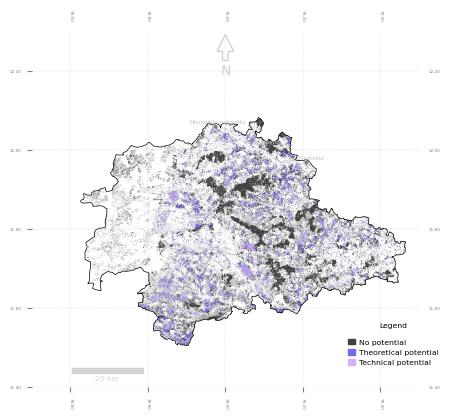

In [147]:
fig8, ax8 = plt.subplots(figsize=(5, 5))

plot_common_features(fig8, ax8)
plot_cities(fig8, ax8)


shp_district.plot(figsize=(5,5),color="none", ax=ax8, linewidth = 0.5, zorder=5)

shp_unused.plot(color="#424242",ax =ax8, label='No Potential')
shp_housing_theo.plot(color="#7869ec",ax =ax8, label='Theoretical Potential')
shp_housing_tech.plot(color="#d2afff",ax =ax8, label='Technical Potential')


No_P = mpatches.Patch(color='#424242', label='No potential')
Theo_P = mpatches.Patch(color='#7869ec', label='Theoretical potential')
Tech_P = mpatches.Patch(color='#d2afff', label='Technical potential')
    
plt.legend(handles = [No_P, Theo_P, Tech_P], loc = 'upper left', bbox_to_anchor=(0.8, 0.2), title = 'Legend\n', fontsize = 5.5, markerscale = 2, title_fontsize = 5.5, framealpha= 0, borderpad = 0.3, handletextpad = 0.5, handlelength = 1.0)

print(plt.rcParams['font.family'])

plt.savefig(get_in_output("images/housing/Technical_suitability.jpg"),dpi =1500)
plt.show()

## Distribution by type

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


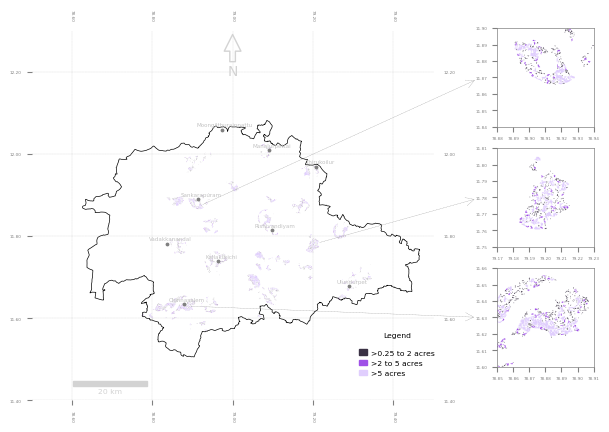

In [23]:
fig9, ax9 = plt.subplots()

plot_common_features(fig9, ax9)
plot_cities(fig9, ax9)
fig9.subplots_adjust(left=0.05, right=0.8)

shp_district.plot(figsize=(5,5),color="none", ax=ax9, linewidth = 0.5)

S1.plot(color="#3a3144",ax =ax9, label='>0.25 to 2 acres')
S2.plot(color="#9f51e7",ax =ax9, label='>2 to 5 acres')
S3.plot(color="#e0cefd",ax =ax9, label='>5 acres')


S1_p = mpatches.Patch(color='#3a3144', label='>0.25 to 2 acres')
S2_p = mpatches.Patch(color='#9f51e7', label='>2 to 5 acres')
S3_p = mpatches.Patch(color='#e0cefd', label='>5 acres')
    
plt.legend(handles = [S1_p, S2_p, S3_p], loc = 'upper left', bbox_to_anchor=(0.8, 0.2), title = 'Legend\n', fontsize = 5.5, markerscale = 2, title_fontsize = 5.5, framealpha= 0, borderpad = 0.3, handletextpad = 0.5, handlelength = 1.0)

# create zoomed inset axes
axins1 = zoomed_inset_axes(ax9, zoom=4, bbox_to_anchor=(1,0.9 ), bbox_transform=ax9.figure.transFigure)

S1.plot(color="#3a3144",ax =axins1, label='>0.25 to 2 acres')
S2.plot(color="#9f51e7",ax =axins1, label='>2 to 5 acres')
S3.plot(color="#e0cefd",ax =axins1, label='>5 acres')
axins1.tick_params(axis='both', colors='grey', labelsize=3)
axins1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axins1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axins1.set_xlim(78.88, 78.94)
axins1.set_ylim(11.84, 11.90)

# Modify the edge color of the inset axes
axins1.spines['top'].set_edgecolor('grey')
axins1.spines['right'].set_edgecolor('grey')
axins1.spines['bottom'].set_edgecolor('grey')
axins1.spines['left'].set_edgecolor('grey')
# Modify the line thickness of the inset axes spines
axins1.spines['top'].set_linewidth(0.5)
axins1.spines['right'].set_linewidth(0.5)
axins1.spines['bottom'].set_linewidth(0.5)
axins1.spines['left'].set_linewidth(0.5)

zoom_patch1 = ConnectionPatch(xyA=(78.91, 11.87), coordsA=ax9.transData,
                             xyB=(78.87, 11.87), coordsB=axins1.transData,
                             arrowstyle="->", shrinkA=5, shrinkB=5,
                             mutation_scale=15, fc="none", ec="grey")
zoom_patch1.set_linestyle('dashed')
zoom_patch1.set_linewidth(0.2)
ax9.add_artist(zoom_patch1)

# create zoomed inset axes
axins2 = zoomed_inset_axes(ax9, zoom=4, bbox_to_anchor=(1,0.65), bbox_transform=ax9.figure.transFigure)

S1.plot(color="#3a3144",ax =axins2, label='>0.25 to 2 acres')
S2.plot(color="#9f51e7",ax =axins2, label='>2 to 5 acres')
S3.plot(color="#e0cefd",ax =axins2, label='>5 acres')
# Modify the edge color of the inset axes
axins2.spines['top'].set_edgecolor('grey')
axins2.spines['right'].set_edgecolor('grey')
axins2.spines['bottom'].set_edgecolor('grey')
axins2.spines['left'].set_edgecolor('grey')
# Modify the line thickness of the inset axes spines
axins2.spines['top'].set_linewidth(0.5)
axins2.spines['right'].set_linewidth(0.5)
axins2.spines['bottom'].set_linewidth(0.5)
axins2.spines['left'].set_linewidth(0.5)

# adjust tick parameters and limits of zoomed inset axes
axins2.tick_params(axis='both', colors='grey', labelsize=3)
axins2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axins2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axins2.set_xlim(79.17, 79.23)
axins2.set_ylim(11.75, 11.81)
zoom_patch2 = ConnectionPatch(xyA=(79.20, 11.78), coordsA=ax9.transData,
                             xyB=(79.16, 11.78), coordsB=axins2.transData,
                             arrowstyle="->", shrinkA=5, shrinkB=5,
                             mutation_scale=15, fc="none", ec="grey")
zoom_patch2.set_linestyle('dashed')
zoom_patch2.set_linewidth(0.2)
ax9.add_artist(zoom_patch2)


axins3 = zoomed_inset_axes(ax9, zoom=4, bbox_to_anchor=(1,0.4), bbox_transform=ax9.figure.transFigure)

S1.plot(color="#3a3144",ax =axins3, label='>0.25 to 2 acres')
S2.plot(color="#9f51e7",ax =axins3, label='>2 to 5 acres')
S3.plot(color="#e0cefd",ax =axins3, label='>5 acres')
# Modify the edge color of the inset axes
axins3.spines['top'].set_edgecolor('grey')
axins3.spines['right'].set_edgecolor('grey')
axins3.spines['bottom'].set_edgecolor('grey')
axins3.spines['left'].set_edgecolor('grey')
# Modify the line thickness of the inset axes spines
axins3.spines['top'].set_linewidth(0.5)
axins3.spines['right'].set_linewidth(0.5)
axins3.spines['bottom'].set_linewidth(0.5)
axins3.spines['left'].set_linewidth(0.5)

# adjust tick parameters and limits of zoomed inset axes
axins3.tick_params(axis='both', colors='grey', labelsize=3)
axins3.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axins3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axins3.set_xlim(78.85, 78.91)
axins3.set_ylim(11.60, 11.66)
zoom_patch3 = ConnectionPatch(xyA=(78.88, 11.63), coordsA=ax9.transData,
                             xyB=(78.84, 11.63), coordsB=axins3.transData,
                             arrowstyle="->", shrinkA=5, shrinkB=5,
                             mutation_scale=15, fc="none", ec="grey")
zoom_patch3.set_linestyle('dashed')
zoom_patch3.set_linewidth(0.2)
ax9.add_artist(zoom_patch3)


plt.savefig(get_in_output("images/housing/Distribution by size.jpg"),dpi =1500)
plt.show()

## High Potential

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


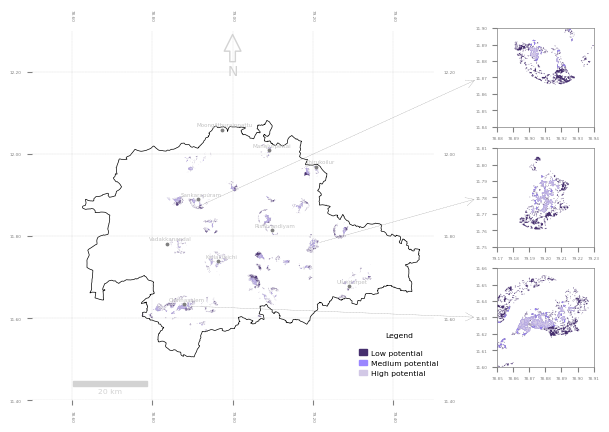

In [25]:
fig9, ax9 = plt.subplots()

plot_common_features(fig9, ax9)
plot_cities(fig9, ax9)
fig9.subplots_adjust(left=0.05, right=0.8)
shp_district.plot(figsize=(5,5),color="none", ax=ax9, linewidth = 0.5, zorder= 1)

shp_housing_tech.plot(color="#462f6e",ax =ax9, label='Low Potential')
shp_housing_med.plot(color="#9a86ff",ax =ax9, label='Medium Potential')
shp_housing_high.plot(color="#d2c8e6",ax =ax9, label='High Potential')


Low_P = mpatches.Patch(color='#462f6e', label='Low potential')
Med_P = mpatches.Patch(color='#9a86ff', label='Medium potential')
High_P = mpatches.Patch(color='#d2c8e6', label='High potential')
    
plt.legend(handles = [Low_P, Med_P, High_P], loc = 'upper left', bbox_to_anchor=(0.8, 0.2), title = 'Legend\n', fontsize = 5.5, markerscale = 2, title_fontsize = 5.5, framealpha= 0, borderpad = 0.3, handletextpad = 0.5, handlelength = 1.0)

# create zoomed inset axes
axins1 = zoomed_inset_axes(ax9, zoom=4, bbox_to_anchor=(1,0.9 ), bbox_transform=ax9.figure.transFigure)

shp_housing_tech.plot(color="#462f6e",ax =axins1, label='Low Potential')
shp_housing_med.plot(color="#9a86ff",ax =axins1, label='Medium Potential')
shp_housing_high.plot(color="#d2c8e6",ax =axins1, label='High Potential')

axins1.tick_params(axis='both', colors='grey', labelsize=3)
axins1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axins1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axins1.set_xlim(78.88, 78.94)
axins1.set_ylim(11.84, 11.90)

# Modify the edge color of the inset axes
axins1.spines['top'].set_edgecolor('grey')
axins1.spines['right'].set_edgecolor('grey')
axins1.spines['bottom'].set_edgecolor('grey')
axins1.spines['left'].set_edgecolor('grey')
# Modify the line thickness of the inset axes spines
axins1.spines['top'].set_linewidth(0.5)
axins1.spines['right'].set_linewidth(0.5)
axins1.spines['bottom'].set_linewidth(0.5)
axins1.spines['left'].set_linewidth(0.5)

zoom_patch1 = ConnectionPatch(xyA=(78.91, 11.87), coordsA=ax9.transData,
                             xyB=(78.87, 11.87), coordsB=axins1.transData,
                             arrowstyle="->", shrinkA=5, shrinkB=5,
                             mutation_scale=15, fc="none", ec="grey")
zoom_patch1.set_linestyle('dashed')
zoom_patch1.set_linewidth(0.2)
ax9.add_artist(zoom_patch1)

# create zoomed inset axes
axins2 = zoomed_inset_axes(ax9, zoom=4, bbox_to_anchor=(1,0.65), bbox_transform=ax9.figure.transFigure)

shp_housing_tech.plot(color="#462f6e",ax =axins2, label='Low Potential')
shp_housing_med.plot(color="#9a86ff",ax =axins2, label='Medium Potential')
shp_housing_high.plot(color="#d2c8e6",ax =axins2, label='High Potential')
# Modify the edge color of the inset axes
axins2.spines['top'].set_edgecolor('grey')
axins2.spines['right'].set_edgecolor('grey')
axins2.spines['bottom'].set_edgecolor('grey')
axins2.spines['left'].set_edgecolor('grey')
# Modify the line thickness of the inset axes spines
axins2.spines['top'].set_linewidth(0.5)
axins2.spines['right'].set_linewidth(0.5)
axins2.spines['bottom'].set_linewidth(0.5)
axins2.spines['left'].set_linewidth(0.5)

# adjust tick parameters and limits of zoomed inset axes
axins2.tick_params(axis='both', colors='grey', labelsize=3)
axins2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axins2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axins2.set_xlim(79.17, 79.23)
axins2.set_ylim(11.75, 11.81)
zoom_patch2 = ConnectionPatch(xyA=(79.20, 11.78), coordsA=ax9.transData,
                             xyB=(79.16, 11.78), coordsB=axins2.transData,
                             arrowstyle="->", shrinkA=5, shrinkB=5,
                             mutation_scale=15, fc="none", ec="grey")
zoom_patch2.set_linestyle('dashed')
zoom_patch2.set_linewidth(0.2)
ax9.add_artist(zoom_patch2)


axins3 = zoomed_inset_axes(ax9, zoom=4, bbox_to_anchor=(1,0.4), bbox_transform=ax9.figure.transFigure)


shp_housing_tech.plot(color="#462f6e",ax =axins3, label='Low Potential')
shp_housing_med.plot(color="#9a86ff",ax =axins3, label='Medium Potential')
shp_housing_high.plot(color="#d2c8e6",ax =axins3, label='High Potential')


axins3.spines['top'].set_edgecolor('grey')
axins3.spines['right'].set_edgecolor('grey')
axins3.spines['bottom'].set_edgecolor('grey')
axins3.spines['left'].set_edgecolor('grey')
# Modify the line thickness of the inset axes spines
axins3.spines['top'].set_linewidth(0.5)
axins3.spines['right'].set_linewidth(0.5)
axins3.spines['bottom'].set_linewidth(0.5)
axins3.spines['left'].set_linewidth(0.5)

# adjust tick parameters and limits of zoomed inset axes
axins3.tick_params(axis='both', colors='grey', labelsize=3)
axins3.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axins3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axins3.set_xlim(78.85, 78.91)
axins3.set_ylim(11.60, 11.66)
zoom_patch3 = ConnectionPatch(xyA=(78.88, 11.63), coordsA=ax9.transData,
                             xyB=(78.84, 11.63), coordsB=axins3.transData,
                             arrowstyle="->", shrinkA=5, shrinkB=5,
                             mutation_scale=15, fc="none", ec="grey")
zoom_patch3.set_linestyle('dashed')
zoom_patch3.set_linewidth(0.2)
ax9.add_artist(zoom_patch3)


plt.savefig(get_in_output("images/housing/High Potential_H_M_L.jpg"),dpi =1500)
plt.show()

# Settlement analysis

In [150]:
shp_village

,gid,dist_name_,ed_distric,drd_dcode,drddcode_1,dist_mmm_1,cen_dcode2,cen_dcod_1,cen_dcode,dcode,...,census_dco,census_pvc,dist_nam_1,dist_mmm_2,ed_distr_2,dist_bk_pv,dist_blk,area_acres,area_class,geometry
0,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,0,0,Kallakurichi,3333,33,3333210,333321,138.038164,C,"POLYGON ((79.06288 11.80400, 79.06329 11.80313..."
1,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,0,0,Kallakurichi,3333,33,3333020,333302,323.110507,C,"POLYGON ((79.16624 12.00525, 79.16661 12.00458..."
2,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,0,0,Kallakurichi,3333,33,3333210,333321,655.955002,C,"POLYGON ((79.05229 11.63973, 79.05227 11.63973..."
3,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,0,0,Kallakurichi,3333,33,3333170,333317,1875.941307,C,"POLYGON ((79.00951 11.66539, 79.00688 11.66568..."
4,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,607,633398,Kallakurichi,3333,33,33331734,333317,207.215194,C,"POLYGON ((78.92296 11.76540, 78.92463 11.76539..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,607,633610,Kallakurichi,3333,33,33330413,333304,1207.327509,C,"POLYGON ((79.35129 11.82988, 79.35246 11.82997..."
456,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,607,633640,Kallakurichi,3333,33,3333033,333303,219.056738,C,"MULTIPOLYGON (((79.39119 11.80037, 79.39312 11..."
457,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,607,633580,Kallakurichi,3333,33,3333056,333305,1327.764815,C,"POLYGON ((79.26622 11.84109, 79.26668 11.84093..."
458,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,607,633535,Kallakurichi,3333,33,3333188,333318,2753.257028,C,"POLYGON ((79.02277 11.60359, 79.02235 11.60371..."


In [151]:
popdf = pd.DataFrame()
for j in range(len(shp_village)):
    input_shp =  get_rooted('workdir/temp_hsing.shp')

    selection = shp_village.geometry[j:j+1]
    if selection.geometry.is_empty.bool():
        rasterarr = []
    else:
        selection.to_file(input_shp)

        input_raster= get_rooted("workdir/raster/population_10_lon_70_general-v1.5.tif")

        output_raster = get_rooted('workdir/temp_hsing.tif')
        ds = gdal.Warp(output_raster,
                      input_raster,
                      format = 'GTiff',
                      cutlineDSName = input_shp,
                      cropToCutline=True,
                      )
        ds = None

        raster = gdal.Open(output_raster, gdal.GA_ReadOnly)
        rasterarr = raster.ReadAsArray()
        #Set -9999 as no data values
        rasterarr = np.where(rasterarr==-9999, np.nan,rasterarr)
        #remove nodata values
        rasterarr = rasterarr[~np.isnan(rasterarr)]


    if (np.size(rasterarr)==0):
        popdf.at[j, "totpop"]=0


    else:    

        pop_sum = rasterarr.sum()

        popdf.at[j, "totpop"]=pop_sum

shp_village_final = pd.concat([shp_village, popdf], axis = 1)

In [152]:
shp_village_final.columns

Index(['gid', 'dist_name_', 'ed_distric', 'drd_dcode', 'drddcode_1',
       'dist_mmm_1', 'cen_dcode2', 'cen_dcod_1', 'cen_dcode', 'dcode',
       'district', 'district_t', 'ogc_fid', 'fid_1', 'p_name', 'd_name',
       'b_name', 'p_name_rd', 'pancha_id', 'block_id_o', 'dist_id',
       'district_r', 'gp_code', 'type1', 'phc', 'hsc', 'remarks', 'ip_address',
       'date_time', 'username', 'drddcode_2', 'block_id', 'ed_distr_1',
       'dist_blk_v', 'village_tn', 'lgd_dcode', 'lgd_vcode', 'census_dco',
       'census_pvc', 'dist_nam_1', 'dist_mmm_2', 'ed_distr_2', 'dist_bk_pv',
       'dist_blk', 'area_acres', 'area_class', 'geometry', 'totpop'],
      dtype='object')

In [153]:
shp_village_final['coords'] = shp_village_final['geometry'].apply(lambda x: x.representative_point().coords[:])
shp_village_final['coords'] = [coords[0] for coords in shp_village_final['coords']]
shp_village_final["coords"].tolist()
shp_village_final[['lat', 'lon']] = gpd.GeoDataFrame(shp_village_final['coords'].tolist(), index=shp_village_final.index) 

In [154]:
shp_village_final = shp_village_final.to_crs(32644)
shp_village_final["TGA(acres)"] = ((shp_village_final.geometry.area)/10**6)*247.105
shp_village_final = shp_village_final.to_crs(4326)

In [155]:
shp_village_tech = find_overlap(shp_village_final,"tech",shp_housing_tech)

In [156]:
# shp_village_tech =  find_overlap(shp_village_tech,"unused",shp_unused)

In [157]:
shp_village_tech = shp_village_tech.to_crs(4326)

In [158]:
shp_village_tech.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 55 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   gid         460 non-null    int64   
 1   dist_name_  460 non-null    object  
 2   ed_distric  460 non-null    object  
 3   drd_dcode   0 non-null      object  
 4   drddcode_1  460 non-null    float64 
 5   dist_mmm_1  0 non-null      object  
 6   cen_dcode2  0 non-null      object  
 7   cen_dcod_1  0 non-null      object  
 8   cen_dcode   0 non-null      object  
 9   dcode       460 non-null    int64   
 10  district    460 non-null    object  
 11  district_t  460 non-null    object  
 12  ogc_fid     460 non-null    int64   
 13  fid_1       460 non-null    int64   
 14  p_name      460 non-null    object  
 15  d_name      460 non-null    object  
 16  b_name      460 non-null    object  
 17  p_name_rd   460 non-null    object  
 18  pancha_id   460 non-null    object  
 19  

In [159]:
shp_village_tech = shp_village_tech.iloc[:, [14,15,16,17] + list(range(44, 55))]

In [160]:
shp_village_tech.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   p_name      460 non-null    object  
 1   d_name      460 non-null    object  
 2   b_name      460 non-null    object  
 3   p_name_rd   460 non-null    object  
 4   area_acres  460 non-null    float64 
 5   area_class  460 non-null    object  
 6   geometry    460 non-null    geometry
 7   totpop      460 non-null    float64 
 8   coords      460 non-null    object  
 9   lat         460 non-null    float64 
 10  lon         460 non-null    float64 
 11  TGA(acres)  460 non-null    float64 
 12  op%tech     460 non-null    object  
 13  opartech    460 non-null    object  
 14  cnttech     460 non-null    object  
dtypes: float64(5), geometry(1), object(9)
memory usage: 54.0+ KB


In [161]:
shp_village_tech.iloc[:,12:15] = shp_village_tech.iloc[:,12:15].astype(float)

C:\Users\User\AppData\Local\Temp\ipykernel_8860\2393764547.py:1: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  shp_village_tech.iloc[:,12:15] = shp_village_tech.iloc[:,12:15].astype(float)


In [162]:
shp_village_tech= shp_village_tech[['p_name', 'd_name', 'b_name', 'p_name_rd', 'area_acres', 'area_class'
       , 'totpop', 'lat', 'lon', 'TGA(acres)', 'op%tech',
       'opartech', 'cnttech','geometry']]

In [163]:
shp_village_tech.to_file(get_in_output("housing/settlement"))

In [164]:
shp_village_tech.columns

Index(['p_name', 'd_name', 'b_name', 'p_name_rd', 'area_acres', 'area_class',
       'totpop', 'lat', 'lon', 'TGA(acres)', 'op%tech', 'opartech', 'cnttech',
       'geometry'],
      dtype='object')

In [165]:
shp_village = shp_village_tech[['p_name', 'd_name', 'b_name', 'p_name_rd', 'area_acres', 'area_class',
       'totpop', 'lat', 'lon', 'TGA(acres)', 'op%tech', 'opartech', 'cnttech']]

In [166]:
shp_village.to_excel(get_in_output("housing/settlement.xlsx"))

In [167]:
shp_village.sort_values("p_name",inplace =True)

C:\Users\User\AppData\Local\Temp\ipykernel_8860\2220424596.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shp_village.sort_values("p_name",inplace =True)


In [168]:
shp_village.reset_index(drop =True,inplace =True)

In [169]:
shp_village_tech.drop("geometry",axis =1,inplace =True)

C:\Users\User\AppData\Local\Temp\ipykernel_8860\181623506.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shp_village_tech.drop("geometry",axis =1,inplace =True)


In [170]:
shp_village.to_excel(get_in_output("housing/230516_settlement_ordered.xlsx"))

# Settlement visuals

In [171]:
settlement = read_df_UT("output/housing/settlement/settlement.shp")

In [172]:
S3 = LinearSegmentedColormap.from_list('testCmap1', colors=["#f2eefc", "#d0c9f8", "#a7a1e9", "#876ce0", "#593596"], N=256)

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

0.0 28.706714863980576


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

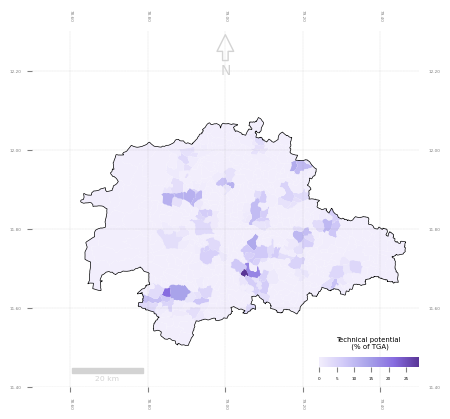

In [173]:

fig, ax = plt.subplots(figsize=(5, 5))

plot_common_features(fig, ax)  # assuming this function is defined elsewhere

shp_district.plot(figsize=(5,5), color="none", ax=ax, linewidth=0.5, zorder=5)
settlement.plot(column='op%tech', cmap=S3, ax=ax)
a = settlement["op%tech"].min()
b = settlement["op%tech"].max()
sm = plt.cm.ScalarMappable(cmap=S3)
cbaxes = fig.add_axes([0.7, 0.18, 0.2, 0.02]) 
cbar = plt.colorbar(sm, orientation = 'horizontal', cax=cbaxes, shrink = 0.2)
cbar.mappable.set_clim(vmin = a, vmax = b)
cbar.ax.tick_params(labelsize=3, color = 'grey')
cbar.outline.set_visible(False)
cbar.ax.set_title('Technical potential \n (% of TGA)', fontsize=5)

print(a,b)

plt.savefig(get_in_output("images/housing/Technical potential area(%).jpg"),dpi =1500)
plt.show()

### Taluk analysis

In [177]:
shp_taluk = gpd.overlay(shp_district,shp_taluk,how="intersection")

In [178]:
popdf = pd.DataFrame()
for j in range(len(shp_taluk)):
    input_shp =  get_rooted('workdir/temp_t_h.shp')

    selection = shp_taluk.geometry[j:j+1]
    if selection.geometry.is_empty.bool():
        rasterarr = []
    else:
        selection.to_file(input_shp)

        input_raster= get_rooted("workdir/raster/population_10_lon_70_general-v1.5.tif")

        output_raster = get_rooted('workdir/temp_t_h.tif')
        ds = gdal.Warp(output_raster,
                      input_raster,
                      format = 'GTiff',
                      cutlineDSName = input_shp,
                      cropToCutline=True,
                      )
        ds = None

        raster = gdal.Open(output_raster, gdal.GA_ReadOnly)
        rasterarr = raster.ReadAsArray()
        #Set -9999 as no data values
        rasterarr = np.where(rasterarr==-9999, np.nan,rasterarr)
        #remove nodata values
        rasterarr = rasterarr[~np.isnan(rasterarr)]


    if (np.size(rasterarr)==0):
        popdf.at[j, "totpop"]=0


    else:    

        pop_sum = rasterarr.sum()

        popdf.at[j, "totpop"]=pop_sum

shp_taluk_final = pd.concat([shp_taluk, popdf], axis = 1)

In [180]:
shp_taluk_final['coords'] = shp_taluk_final['geometry'].apply(lambda x: x.representative_point().coords[:])
shp_taluk_final['coords'] = [coords[0] for coords in shp_taluk_final['coords']]
shp_taluk_final["coords"].tolist()
shp_taluk_final[['lat', 'lon']] = gpd.GeoDataFrame(shp_taluk_final['coords'].tolist(), index=shp_taluk_final.index) 

In [181]:
shp_taluk_final = shp_taluk_final.to_crs(32644)
shp_taluk_final["TGA(acres)"] = ((shp_taluk_final.geometry.area)/10**6)*247.105
shp_taluk_final = shp_taluk_final.to_crs(4326)

In [182]:
shp_taluk_final = find_overlap(shp_taluk_final,"tech",shp_housing_tech)

In [183]:
# shp_taluk_final['geometry'] = shp_taluk_final['geometry'].apply(lambda x: shape(x).buffer(0).buffer(0.0000000000001))
# shp_taluk_finalshp_taluk_final = gpd.GeoDataFrame(shp_taluk_final, geometry='geometry')
# shp_taluk_final = shp_taluk_final.loc[shp_taluk_final.is_valid]

In [184]:
# shp_taluk_final =  find_overlap(shp_taluk_final,"unused",shp_unused)

In [185]:
shp_taluk_final = shp_taluk_final.to_crs(4326)

In [186]:
shp_taluk_final= shp_taluk_final[['Taluk_name', 'area_acres', 'area_class'
       , 'totpop', 'lat', 'lon', 'TGA(acres)', 'op%tech',
       'opartech', 'cnttech','geometry']]

In [187]:
shp_taluk_final.totpop.sum()

1544317.7988980003

In [188]:
shp_taluk_final.to_file(get_in_output("housing/shp_taluk"))

In [189]:
shp_taluk_final.drop("geometry",axis =1,inplace =True)

In [190]:
shp_taluk_final.to_excel(get_in_output("housing/taluk_analysis.xlsx"))